<h1>A Recommender System for building an Indian restaurant in New York</h1>

<h3><b>Brief Introduction</b></h3><br/>


<i>Project Description</i><br/>
    
  <b>  New York City's demographics show that it is a large and ethnically diverse metropolis. It is the largest city in the United States with a long history of international immigration. New York City was home to nearly 8.5 million people in 2018, accounting for over 40% of the population of New York State and a slightly lower percentage of the New York metropolitan area, home to approximately 23.6 million. Over the last decade the city has been growing faster than the region. The New York region continues to be by far the leading metropolitan gateway for legal immigrants admitted into the United States.<br/>
 </b><b>   
    In this project we will go through the entire neighborhood of New York by analyzing the chain of restaurants serving Indian food nearby.By doing this we will be able to decide whether it is wise to open an Indian restaurant. For analysis we will find the preferred cuisine of the population, most profitable area as to figure out the area where most of the population visits. If the area is profitable, where exactly the restaurant should be so that the business yields more profit to the owner.
</b>

<h3><b>Business Problem</b></h3><br/>
<b>
1. What is / are the best location(s) for Indian cuisine in New York City?<br/>
2. In what Neighborhood and/or borough should the investor open a Indian restaurant to have the best chance of being successful?<br/>
3. Where would I go in New York City to have the best Indian food?
    </b>

<h3><b>Methodology</b></h3>
<b>
<br/>
1. Data will be collected from https://cocl.us/new_york_dataset and cleaned and processed into a dataframe.<br/>
2. FourSquare be used to locate all venues and then filtered by Japanese restaurants. Ratings, tips, and likes by users will be counted and        added to the dataframe.<br/>
3. Data will be sorted based on rankings.<br/>
4. Finally, the data be will be visually assessed using graphing from Python libraries.
</b>

<h3><b>Data to be used</b></h3><br/>
<b>

Data Sources:<br/>

a) Then I’m using “https://cocl.us/new_york_dataset” csv file to get all the geographical coordinates of the neighborhoods.<br/>

b) To get location and other information about various venues in New York I’m using Foursquare’s explore API. Using the Foursquare’s explore API (which gives venues recommendations), I’m fetching details about the venues up present in Toronto and collected their names, categories and locations (latitude and longitude).<br/>
From Foursquare API (https://developer.foursquare.com/docs), I retrieved the following for each venue:<br/>
&nbsp;&nbsp;Name: The name of the venue.<br/>
&nbsp;&nbsp;Category: The category type as defined by the API.<br/>
&nbsp;&nbsp;Latitude: The latitude value of the venue.<br/>
&nbsp;&nbsp;Longitude: The longitude value of the venue.<br/><br/>
All data related to locations and quality of Indian restaurants will be obtained via the FourSquare API utilized via the Request library in Python.</b>

In [118]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd
# library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    branca-0.4.1               |             py_0          26 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    ------------------------------------------------------------
                       

In [120]:
# Define Foursquare Credentials and Version

CLIENT_ID = 'NZXUVCPH425JIXWG45WLNRI0HII5FI2CIR0NL4GAQZAECLVF' # your Foursquare ID
CLIENT_SECRET = 'T4SSLPHS2YXDIOEGFNEP40EC1XBMF05VEVCPJRKDRCUYMJBN' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [121]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [122]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [123]:
ny_data.shape

(306, 4)

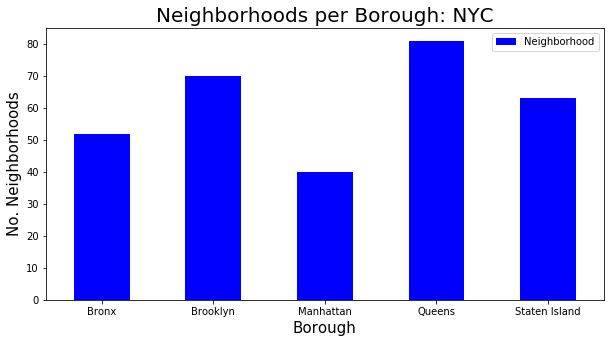

In [124]:
import matplotlib.pyplot as plt
clr = "blue"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [125]:

# prepare neighborhood list that contains indian restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_restaurants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(ny_data),')','Indian Restaurants in '+Neighborhood+', '+Borough+':'+str(len(indian_restaurants)))
    print(row)
    for resturant_detail in indian_restaurants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Indian Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Indian Restaurants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Indian Restaurants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Indian Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Indian Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Indian Restaurants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Indian Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Indian Restaurants in Woodlawn, Bronx:1
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Indian Restaurants in Norwood, Bronx:0
['Bronx', '

In [126]:
indian_rest_ny.to_csv('indian_rest_ny_tocsv1.csv')


In [127]:

indian_ny = pd.read_csv('indian_rest_ny_tocsv1.csv')
indian_rest_ny.tail()

,Borough,Neighborhood,ID,Name
35,Manhattan,Civic Center,575dea4c498e2739e43a27e2,Aahar Indian Cuisine
36,Manhattan,Civic Center,50b02338e4b047828b2277c1,Benares
37,Queens,Jamaica Hills,4c434b2bd691c9b6ef8f8f0a,Sagar Restaurant
38,Manhattan,Sutton Place,4fe4fb50c2eee335e4fea69d,Moti Mahal Delux
39,Queens,Sunnyside Gardens,4c48da9f3013a59356c5f0e1,Saffron Garden


In [128]:
indian_rest_ny.shape

(40, 4)

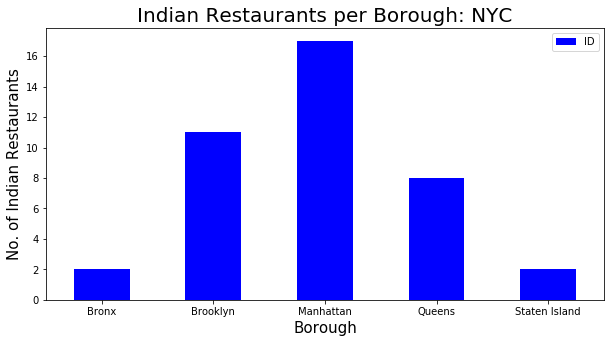

In [129]:
indian_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Indian Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Indian Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

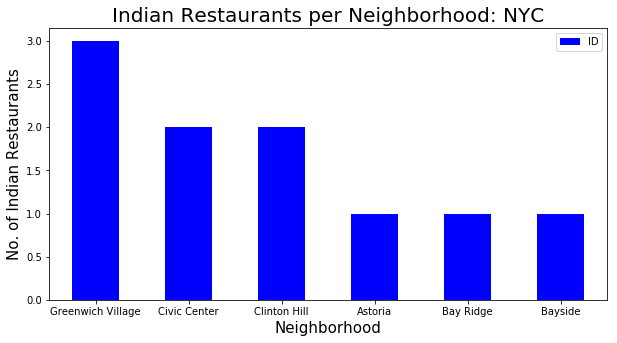

In [130]:
NOofNeigh = 6 # top number for graphing all the same past 6
japanese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Indian Restaurants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No. of Indian Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [131]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Greenwich Village']

,Borough,Neighborhood,ID,Name
19,Manhattan,Greenwich Village,56c931b2cd10407d3ecbefda,Ananda
20,Manhattan,Greenwich Village,4593ed04f964a52050401fe3,The Kati Roll Company
21,Manhattan,Greenwich Village,4d992c1e942ba093ebb5968c,THELEwala


In [138]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
indian_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '5f319371dfd3a31abbb0dba2'}, 'response': {'venue': {'id': '4c0448d9310fc9b6bf1dc761', 'name': 'Curry Spot', 'contact': {'phone': '7187085900', 'formattedPhone': '(718) 708-5900'}, 'location': {'address': '4268 Katonah Ave', 'crossStreet': 'E 235 Street', 'lat': 40.897624941880906, 'lng': -73.86714729157393, 'labeledLatLngs': [{'label': 'display', 'lat': 40.897624941880906, 'lng': -73.86714729157393}, {'label': 'entrance', 'lat': 40.897709, 'lng': -73.86707}], 'postalCode': '10470', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4268 Katonah Ave (E 235 Street)', 'Bronx, NY 10470', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/curry-spot/4c0448d9310fc9b6bf1dc761', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
35,Manhattan,Civic Center,575dea4c498e2739e43a27e2,Aahar Indian Cuisine,53,8.1,20
36,Manhattan,Civic Center,50b02338e4b047828b2277c1,Benares,97,7.5,44
37,Queens,Jamaica Hills,4c434b2bd691c9b6ef8f8f0a,Sagar Restaurant,10,7.3,6
38,Manhattan,Sutton Place,4fe4fb50c2eee335e4fea69d,Moti Mahal Delux,185,8.2,83
39,Queens,Sunnyside Gardens,4c48da9f3013a59356c5f0e1,Saffron Garden,17,7.7,16


So the Greenwich Village in Manhattan has the highest number of Indian Restaurants with a total count of 3.

Now we will get the ranking of each restaurant for further analysis.

In [143]:
indian_rest_stats_ny.to_csv('indian_rest_stats_ny_csv.csv') # As I move through this project I continue to save data to a .csv file

In [144]:
indian_rest_stats_ny.shape()

TypeError: 'tuple' object is not callable

In [145]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 7 columns):
Borough         40 non-null object
Neighborhood    40 non-null object
ID              40 non-null object
Name            40 non-null object
Likes           40 non-null object
Rating          40 non-null float64
Tips            40 non-null object
dtypes: float64(1), object(6)
memory usage: 2.3+ KB


We see that the values like Likes, Tips are string values. We would need to convert them into float for further analysis

In [146]:

indian_rest_stats_ny['Likes'] = indian_rest_stats_ny['Likes'].astype('float64')
indian_rest_stats_ny['Tips'] = indian_rest_stats_ny['Tips'].astype('float64')
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 7 columns):
Borough         40 non-null object
Neighborhood    40 non-null object
ID              40 non-null object
Name            40 non-null object
Likes           40 non-null float64
Rating          40 non-null float64
Tips            40 non-null float64
dtypes: float64(3), object(4)
memory usage: 2.3+ KB


In [147]:
indian_rest_stats_ny.describe()

,Likes,Rating,Tips
count,40.000000,40.000000,40.000000
mean,94.450000,7.427500,32.750000
std,169.881399,1.921136,50.561336
min,0.000000,0.000000,0.000000
25%,13.500000,7.450000,7.500000
50%,33.000000,7.850000,16.500000
75%,85.250000,8.400000,27.500000
max,832.000000,9.100000,256.000000


In [148]:

# Resturant with maximum Likes
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                832
Rating                               8.4
Tips                                 256
Name: 17, dtype: object

In [149]:
# Resturant with maximum Ratings
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                598
Rating                               9.1
Tips                                 148
Name: 22, dtype: object

In [150]:
# Resturant with maximum Tips
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                832
Rating                               8.4
Tips                                 256
Name: 17, dtype: object

Now let's identify and visualize neighborhood with the maximum average rating of restaurants

In [151]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
30,Tribeca,9.1
23,Noho,8.8
11,Fort Greene,8.8
26,Prospect Lefferts Gardens,8.7
8,Chelsea,8.7
14,Greenwich Village,8.6
25,North Side,8.5
34,West Village,8.5
21,Midtown,8.4
0,Astoria,8.4


Above are the top neighborhoods with the highest average ratings of Indian restaurants.

In [152]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.241176
1,Brooklyn,7.427273
0,Bronx,7.000000
3,Queens,6.637500
4,Staten Island,4.100000


Similarly above are the average ratings of Indian Restaurants for each Borough

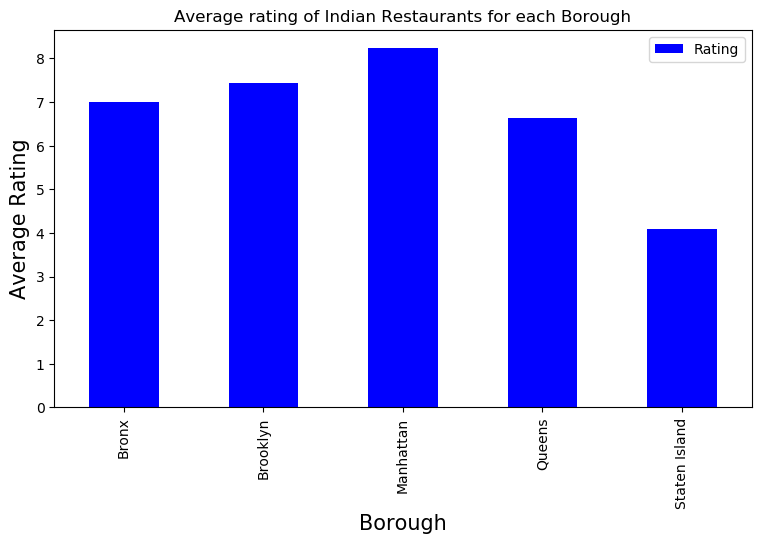

In [153]:
#visualize


plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Indian Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color=clr)
plt.legend()
plt.show()

In [154]:
#We will consider all the neighborhoods with average rating greater or equal 8.0 to visualize on a map

ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Astoria,8.4
2,Bayside,8.4
6,Carnegie Hill,8.1
8,Chelsea,8.7
11,Fort Greene,8.8
14,Greenwich Village,8.6
17,Kew Gardens,8.0
21,Midtown,8.4
22,New Dorp,8.2
23,Noho,8.8


We will join this Dataset to original New York data to get longitude and latitude

In [155]:

ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Astoria,40.768509,-73.915654,8.4
1,Queens,Bayside,40.766041,-73.774274,8.4
2,Manhattan,Carnegie Hill,40.782683,-73.953256,8.1
3,Manhattan,Chelsea,40.744035,-74.003116,8.7
4,Staten Island,Chelsea,40.594726,-74.189560,8.7
5,Brooklyn,Fort Greene,40.688527,-73.972906,8.8
6,Manhattan,Greenwich Village,40.726933,-73.999914,8.6
7,Queens,Kew Gardens,40.705179,-73.829819,8.0
8,Manhattan,Midtown,40.754691,-73.981669,8.4
9,Staten Island,New Dorp,40.572572,-74.116479,8.2


In [156]:
#visualize
!pip install folium
import folium
from geopy.geocoders import Nominatim
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [157]:
#add a new field to the dataframe


ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)

<h3><b>Results</b></h3><br/>

Manhattan and Brooklyn have the best rated Indian restaurants on average. Staten Island and Queens have the least amount of Indian restaurants per borough. However, of note, Greenwich Village in Manhattan has the highest number of Indian Restaurants in all of NY. Despite Manhattan having the least number of neighborhoods in all five boroughs, it has the most number of Indian restaurants. Based on the above information, I would state that Manhattan and Brooklyn are the best locations for Indian cuisine in NYC. To have the best shot of success, I would open a Indian restaurant in Brooklyn. Brooklyn has multiple neighborhoods with average ratings exceeding 8.0 on a scale of 1.0 to 10.0 and has less amount of Indian restaurants than Manhattan, making competition easier. Also we should keep in mind, that real estate prices in Brooklyn are much cheaper than in Manhattan. Finally, I would go to Kati Roll Company in Manhattan for the best Indian food based on 832 likes. As a final note, all of the above analysis is depended on the accuracy of Four Square data. A more comprehensive analysis and future work would need to incorporate data from other external databases